
# Denoising Autoencoder

In this notebook, you will implement a denoising autoencoder using convolutional layers that will be capable of denoising the MNIST digits.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from visualize_util import visualize_img_batch

In [2]:
# Use this if you are using any Cuda enabled system
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Load MNIST Dataset 

In [3]:
# TODO:convert data to torch.FloatTensor
transform = transforms.Compose(
        [transforms.ToTensor()]
    ) 

# load the training and test datasets
mnist_train = datasets.MNIST('./data', train=True,
                                   download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False,
                                  download=True, transform=transform)

#TODO
n_epochs = 20
batch_size = 64

# prepare data loaders
loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 39654717.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1120444.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 14395690.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7798006.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Visualize the Data

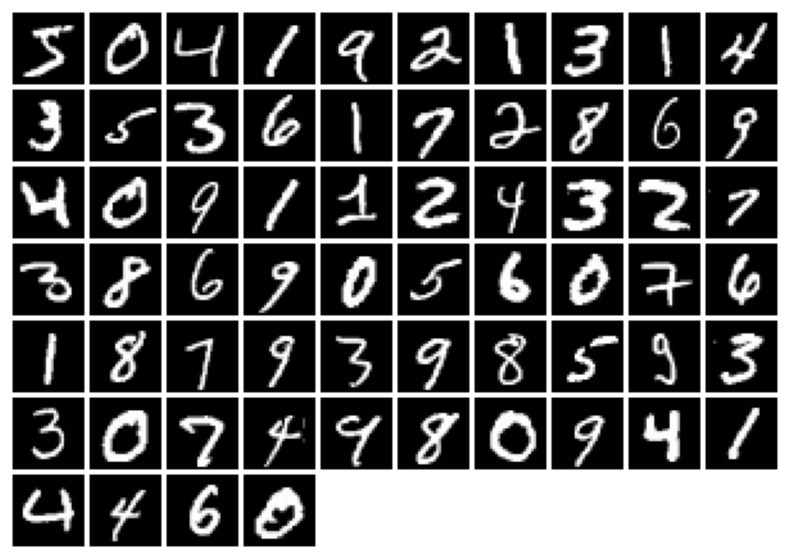

In [4]:
imgs = next(iter(loader_train))[0].numpy().squeeze()
visualize_img_batch(imgs)

In [5]:

# Denoise Autoencoder
class DenoiseAE(nn.Module):
    def __init__(self):
        super(DenoiseAE, self).__init__()
        #TODO
        hidden_dims = [32, 22, 16] # latent layers channels
        # for every block in the encoder (conv + max pool)  the size of the image is reduced by half
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dims[0], kernel_size = 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(hidden_dims[0], hidden_dims[1], kernel_size = 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dims[1]),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding=1),
            nn.Conv2d(hidden_dims[1], hidden_dims[2], kernel_size = 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dims[2]),
            nn.MaxPool2d(kernel_size = 2, stride=2),
             
        ) # out = (4,4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[2], hidden_dims[1], kernel_size = 2, stride=2, bias=False),
            nn.BatchNorm2d(hidden_dims[1]),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_dims[1], hidden_dims[0], kernel_size = 2, stride=2, padding=1,bias=False), # padding to make sure output the same shape as input
            nn.BatchNorm2d(hidden_dims[0]),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(hidden_dims[0], 1, kernel_size = 2, stride=2, bias=False),
            nn.Sigmoid() # ensure output is between 0 and 1
        )
    
    def forward(self,x):
        #TODO
        # pass
        z = self.encoder(x)
        # print("bottle neck shape", z.shape)
        out = self.decoder(z)
        # print("out shape", out.shape)
        # print("if output shape = input shape", out.shape == x.shape) 
        return out

In [6]:
from torchsummary import summary
denoise_autoencoder = DenoiseAE().to(device)
summary(denoise_autoencoder,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         LeakyReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 22, 14, 14]           6,336
       BatchNorm2d-6           [-1, 22, 14, 14]              44
         LeakyReLU-7           [-1, 22, 14, 14]               0
         MaxPool2d-8             [-1, 22, 8, 8]               0
            Conv2d-9             [-1, 16, 8, 8]           3,168
      BatchNorm2d-10             [-1, 16, 8, 8]              32
        MaxPool2d-11             [-1, 16, 4, 4]               0
  ConvTranspose2d-12             [-1, 22, 8, 8]           1,408
      BatchNorm2d-13             [-1, 22, 8, 8]              44
        LeakyReLU-14             [-1, 2

---
## Training


In [7]:
from tqdm import tqdm
criterion = nn.MSELoss() # TODO: specify loss function
lr = 5e-3
optimizer = torch.optim.Adam(denoise_autoencoder.parameters(), lr = lr) # TODO: specify optimizer

noise_factor=0.5
logs = {"train_loss": []}

for epoch in range(n_epochs):
    train_loss = 0.0
    #TODO
    with tqdm(loader_train, unit="batch") as tepoch:
        for images, _ in tepoch:
            tepoch.set_description("Epoch[{:2d}/{}] train".format(epoch+1, n_epochs))
            
            # reset gradient 
            optimizer.zero_grad()
            # add random noise to the input images
            noisy_imgs = images + noise_factor * torch.randn(*images.shape)
            # Clip the images to be between 0 and 1
            noisy_imgs = torch.clip(noisy_imgs, 0., 1.).to(device)
            # Use the noisy images during the forward pass
            out = denoise_autoencoder(noisy_imgs)
            # calculate the loss between the original (not-noisy) and the predicted
            loss = criterion(out, images.to(device))
            # Backward pass        
            loss.backward()
            optimizer.step() 
            # update running training loss
            train_loss += loss.item()/len(loader_train)
            tepoch.set_postfix(train_loss=train_loss)
            
    # print avg training statistics 
    logs["train_loss"].append(train_loss)
    # print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch[20/20] train: 100%|██████████| 938/938 [00:05<00:00, 183.97batch/s, train_loss=0.0138] 


## Results


noisy images:


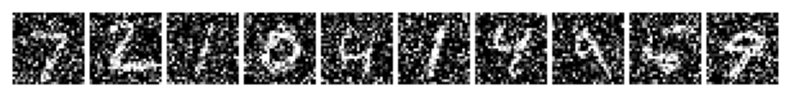

denoised images:


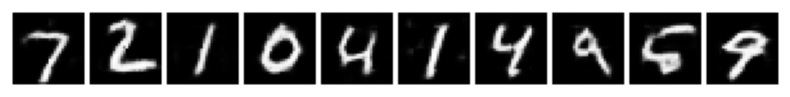

In [8]:
images = next(iter(loader_test))[0][0:10,:,:,:] # assume batch size >10

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = torch.clip(noisy_imgs, 0., 1.)

# show noisy images
print('noisy images:')
visualize_img_batch(noisy_imgs.numpy().squeeze())
plt.show()

# get sample outputs
output = denoise_autoencoder(noisy_imgs.to(device))

# show denoised images
print('denoised images:')
visualize_img_batch(output.detach().cpu().numpy().squeeze())
plt.show()

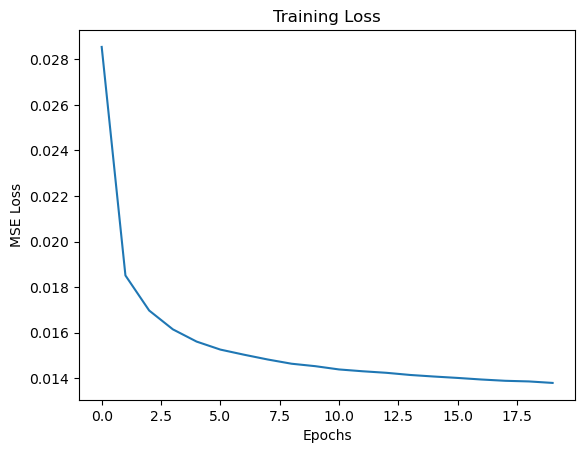

In [10]:
# save log 
import json 
with open('./logs/denoise_cae.json', 'w') as f:
    json.dump(logs, f)
    
import matplotlib.pyplot as plt
plt.plot(logs["train_loss"])
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.savefig("./figs/denoise_cae_loss.png")